Attempting to use the approximation method presented in https://pubmed.ncbi.nlm.nih.gov/29454104/.

| **Parameter or variable** | **Role** |
|---------------------------|----------|
| $\mathcal{G}$            | Structural network of $N$ nodes |
| $\mathcal{V}$            | Set of nodes of $\mathcal{G}$ |
| $\mathcal{V}_i$          | $i$th node of $\mathcal{G}$ |
| $\mathcal{E}$            | Set of edges of $\mathcal{G}$ |
| $\mathbf{C}_s$           | Structural connectivity matrix |
| $C_{ij}$                 | Element $(i,j)$ of $\mathbf{C}_s$ |
| $\mathbf{C}_f$           | Functional connectivity matrix |
| $\mathbf{C}_f^{GD}$      | Graph diffusion estimate of $\mathbf{C}_f$ |
| $\mathbf{C}_f^{eig}$     | Eigen decomposition estimate of $\mathbf{C}_f$ |
| $\delta_i$               | Weighted degree of node $i$ |
| $\mathcal{L}$            | Laplacian of $\mathbf{C}_s$ |
| $\mathbf{U}_l$           | Eigenvectors of $\mathcal{L}$ |
| $\Lambda_l$              | Eigenvalues of $\mathcal{L}$ |
| $\Lambda_f^{eig}$        | Proposed model eigenvalues |
| $\Lambda_f^{GD}$         | Eigenvalues of the GD model |
| $\mathbf{u}_i$           | $i$th eigenvector of $\mathcal{L}$ |
| $\Delta$                 | Diagonal degree matrix of $\mathbf{C}_s$ |
| $\beta$                  | Diffusion rate |


$\mathbf{C}_f^{eig} = \sum_{i \in M} u_i u_i^{\prime} \left(a e^{-\alpha \lambda_i} + b\right)$

$M$ is a subset of indices of eigenvectors to use for the approximation.

In [59]:
import numpy as np
from scipy.sparse.linalg import eigsh

In [60]:
def compute_C_f(M, U, L, a, alpha, b):
    '''
    M: subset of indices
    U: eigenvector matrix
    L: eigenvalue matrix
    '''

    n, m = U.shape
    Cf_eig = np.zeros((n, n))  # Initialize the result matrix
    
    # Ensure M does not exceed the number of available eigenvectors
    M = min(M, m)
    
    for i in range(M):  # Loop over the first M eigenvectors
        u_i = U[:, i].reshape(-1, 1)  # Extract eigenvector u_i and make it a column vector
        term = a * np.exp(-alpha * L[i]) + b  # Compute the scalar term
        Cf_eig += term * (u_i @ u_i.T)  # Accumulate the rank-1 matrix
        
    return Cf_eig

In [61]:
def get_spectrum(C):
    evals, evecs = np.linalg.eig(C)

    sorted_indices = np.argsort(evals)[::-1]
    sorted_eigenvalues = evals[sorted_indices]
    sorted_eigenvectors = evecs[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

In [62]:
def get_laplacian(C):
    D = np.diag(np.sum(C, axis=1))
    laplacian = D - C

    return laplacian

In [63]:
from Connectome import *

In [68]:
connectome = Connectome(file='/Users/shamanthk/Documents/Research/IS-modeling-connectomes/Averaged_1015.graphml', label='Average')
C_s = connectome.read_matrix()

In [65]:
L_s = get_laplacian(C_s)

L_s_evals, L_s_evecs = get_spectrum(L_s)

In [104]:
a = 1.0
b = 0.5
alpha = 0.1
M = 6

C_f = compute_C_f(M, L_s_evecs, L_s_evals, a, alpha, b)

C_f_evals, C_f_evecs = get_spectrum(C_f)
C_f_evals, C_f_evecs = np.real(C_f_evals), np.real(C_f_evecs)
C_s_evals, C_s_evecs = get_spectrum(C_s.toarray())
C_s_evals, C_s_evecs = np.real(C_s_evals), np.real(C_s_evecs)

In [105]:
C_f_evecs[0]

array([-0.00109102, -0.00058958,  0.0014168 , ..., -0.01330895,
        0.0071596 ,  0.0071596 ])

In [106]:
L_s_evecs[0]

array([-6.22039496e-05, -1.25802689e-04,  1.42825172e-03, ...,
       -3.36978953e-04, -1.83930090e-03, -3.13882410e-02])

In [109]:
L_s_evals.shape

(1015,)

In [78]:
C_s_evecs.shape

(1015, 1015)

Should they not be the same?

In [121]:
L_s_evals = (L_s_evals - min(L_s_evals)) / (max(L_s_evals) - min(L_s_evals))
C_f_evals = (C_f_evals - min(C_f_evals)) / (max(C_f_evals) - min(C_f_evals))

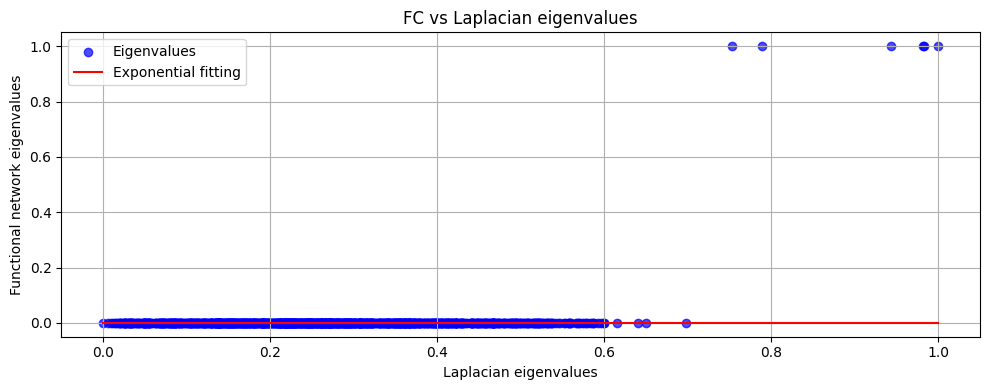

In [128]:
from scipy.optimize import curve_fit

def exponential_fit(x, a, b):
    return a * np.exp(-b * x)

params, _ = curve_fit(exponential_fit, L_s_evals, C_f_evals)
a, b = params

plt.figure(figsize=(10, 4))
plt.scatter(L_s_evals, C_f_evals, color='b', label='Eigenvalues', alpha=0.7)
plt.plot(L_s_evals, exponential_fit(L_s_evals, a, b), color='r', label='Exponential fitting')
plt.title("FC vs Laplacian eigenvalues")
plt.xlabel("Laplacian eigenvalues")
plt.ylabel("Functional network eigenvalues")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()